<a href="https://colab.research.google.com/github/gimb99/PDI_BARTHOU_GONZALO/blob/develop/003-IntegradorFinal/TP02_Proyecto_Escaneo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Fuentes:
Edje Electronics (Evan Juras)

* https://www.youtube.com/watch?v=r0RspiLG260 (Tutorial base)

* https://www.ejtech.io/learn/train-yolo-models

* https://github.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/blob/main/yolo_detect.py (Script para Deploy)


Universidad de Freiburg

* http://mobility-aids.informatik.uni-freiburg.de/ (Dataset posteriormente etiquetado para YOLOV8)


## Pre-requisitos

* Python 3.12 para la base de codigo
* Anaconda para manejo de ambientes de desarrollo
* Google Colab para armado de código
* Python -> Ultralytics (Incluye OpenCV, numPy, pyTorch)

### Runtime (NVIDIA)
Para el correcto funcionamiento de este notebook necesitamos usar un entorno de ejecución T4.
Para ello deberemos dirigirnos a:
1. Entorno de Ejecución
2. Cambiar tipo de entorno de ejecucion
3. Elegir GPU T4
4. Guardar proyecto
5. Hacer click en Conectar

In [1]:
!nvidia-smi

Thu Jun 19 04:39:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   56C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Librerías

In [2]:
# Google Drive
from google.colab import drive
# Ultralytics - Incluye OpenCV, pyTorch, etc...
# Usado para entrenar modelo YOLO
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 44.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

## Dataset - Imagenes taggeadas

### Preparación

### Import

Para este proyecto estaremos usando una importación de datos via **Google Drive**

Esta opción es ideal si subimos las imágenes con antelación para no tener que esperar a que se carguen cada vez que reinicias Colab. Si tenemos más de 50 MB de imágenes, te recomiendo usar esta opción.

Primero, subiremos el archivo `data.zip` a Google Drive y anota la carpeta donde lo subiste.

Luego, ejecutaremos el siguiente bloque de código para montar tu Google Drive en esta sesión de Colab y copiar la carpeta a este sistema de archivos.


In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
path = "/content/gdrive/MyDrive/pdiRecursosDataIntegrador/datav8.zip"
!cp /content/gdrive/MyDrive/pdiRecursosDataIntegrador/datav8.zip /content

## Training

### Splitteo de Dataset (Train - Validate)

In [5]:
# Unzip images to a custom data folder
# !unzip -q /content/data.zip -d /content/custom_data
!unzip -q /content/datav8.zip -d /content/custom_data

Ultralytics requiere una estructura de carpetas específica para almacenar los datos de entrenamiento de los modelos. La carpeta raíz se llama "data". Dentro, hay dos carpetas principales:

* **Train**: Estas son las imágenes utilizadas para entrenar el modelo. En una época de entrenamiento, cada imagen del conjunto de entrenamiento se pasa a la red neuronal. El algoritmo de entrenamiento ajusta los pesos de la red para que se ajusten a los datos de las imágenes.

* **Validation**: Estas imágenes se utilizan para comprobar el rendimiento del modelo al final de cada época de entrenamiento.

En cada una de estas carpetas hay una carpeta "images" y una carpeta "labels", que contienen los archivos de imagen y los archivos de anotación, respectivamente.

---

Usaremos un script escrito por Edje que crea automáticamente la estructura de carpetas requerida y mueve aleatoriamente el 90 % del conjunto de datos a la carpeta "train" y el 10 % a la carpeta "validation".

In [6]:
!wget -O /content/train_val_split.py https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/utils/train_val_split.py

# TO DO: Improve robustness of train_val_split.py script so it can handle nested data folders, etc
!python train_val_split.py --datapath="/content/custom_data" --train_pct=0.9

--2025-06-19 04:41:24--  https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/utils/train_val_split.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3203 (3.1K) [text/plain]
Saving to: ‘/content/train_val_split.py’

/content/train_val_ 100%[===================>]   3.13K  --.-KB/s    in 0s      

2025-06-19 04:41:25 (46.7 MB/s) - ‘/content/train_val_split.py’ saved [3203/3203]

Created folder at /content/data/train/images.
Created folder at /content/data/train/labels.
Created folder at /content/data/validation/images.
Created folder at /content/data/validation/labels.
Number of image files: 89
Number of annotation files: 89
Images moving to train: 80
Images moving to validation: 9


### Pre-Configuraciones

Hay un último paso antes de ejecutar el entrenamiento: necesitamos crear el archivo YAML de configuración de entrenamiento de Ultralytics.

Este archivo especifica la ubicación de los datos de entrenamiento y validación, y también define las clases del modelo. Un ejemplo de modelo de archivo de configuración está disponible [aquí](https://github.com/ultralytics/ultralytics/blob/main/ultralytics/cfg/datasets/coco128.yaml).

El siguiente bloque de código genera automáticamente un archivo de configuración `data.yaml`.
Para esto hay que asegurarse de tener un archivo de mapa de etiquetas en `custom_data/classes.txt`.

En nuestro caso, al usar Label Studio con un export para YOLOV8 / YOLO, ya debería estar presente.

Si se llega a ensamblar a mano o de otra forma el conjunto, es posible que tengamos que crear manualmente el archivo `classes.txt` (consulta [aquí](https://github.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/blob/main/doc/classes.txt) para ver un ejemplo de cómo está formateado).

In [7]:
# Python function to automatically create data.yaml config file
# 1. Reads "classes.txt" file to get list of class names
# 2. Creates data dictionary with correct paths to folders, number of classes, and names of classes
# 3. Writes data in YAML format to data.yaml

import yaml
import os

def create_data_yaml(path_to_classes_txt, path_to_data_yaml):

  # Read class.txt to get class names
  if not os.path.exists(path_to_classes_txt):
    print(f'classes.txt file not found! Please create a classes.txt labelmap and move it to {path_to_classes_txt}')
    return
  with open(path_to_classes_txt, 'r') as f:
    classes = []
    for line in f.readlines():
      if len(line.strip()) == 0: continue
      classes.append(line.strip())
  number_of_classes = len(classes)

  # Create data dictionary
  data = {
      'path': '/content/data',
      'train': 'train/images',
      'val': 'validation/images',
      'nc': number_of_classes,
      'names': classes
  }

  # Write data to YAML file
  with open(path_to_data_yaml, 'w') as f:
    yaml.dump(data, f, sort_keys=False)
  print(f'Created config file at {path_to_data_yaml}')

  return

# Define path to classes.txt and run function
path_to_classes_txt = '/content/custom_data/classes.txt'
path_to_data_yaml = '/content/data.yaml'

create_data_yaml(path_to_classes_txt, path_to_data_yaml)

print('\nFile contents:\n')
!cat /content/data.yaml

Created config file at /content/data.yaml

File contents:

path: /content/data
train: train/images
val: validation/images
nc: 5
names:
- andador con ruedas
- andador estandar
- baston
- muleta
- silla de ruedas


### Entrenamiento de modelo

#### Parametros de entrenamiento

Ahora que los datos están organizados y el archivo de configuración creado, estamos listos para empezar a entrenar

Primero, hay que decidir algunos parámetros importantes.

*Consulta mi artículo sobre el entrenamiento local de modelos YOLO para obtener más información sobre estos parámetros y cómo elegirlos. https://www.ejtech.io/learn/train-yolo-models*

#### Arquitectura y tamaño del modelo (`model`):

Los modelos más grandes funcionan más lento, pero tienen mayor precisión, mientras que los modelos más pequeños funcionan más rápido, pero tienen menor precisión.

*Edje Electronics tiene un breve video en YouTube que compara el rendimiento de diferentes modelos YOLO (https://www.youtube.com/watch?v=_WKS4E9SmkA) para tener una idea de su velocidad y precisión.*

Dada la duración corta del proyecto, podemos tomar como punto de partida yolov8.pt dada la alta compatibilidad

También se pueden entrenar modelos YOLOv5 sustituyendo yolo11 /yolov8 por yolov5.

#### Número de épocas (`epochs`)

En aprendizaje automático, una "época" o epoch es una sola pasada por todo el conjunto de datos de entrenamiento.

La configuración del número de epochs determina la duración del entrenamiento del modelo.

La cantidad óptima de epochs depende del tamaño del conjunto de datos y de la arquitectura del modelo. Si su conjunto de datos tiene menos de 200 imágenes, un buen punto de partida son 60 epochs. Si el conjunto de datos tiene más de 200 imágenes, un buen punto de partida son 40 epochs.


#### Resolución (`imgsz`)

La resolución tiene un gran impacto en la velocidad y la precisión del modelo: un modelo de menor resolución tendrá mayor velocidad, pero menor precisión.

Los modelos YOLO suelen entrenarse e inferirse con una resolución de 640x640, pero podemos ajustarlos a una resolución más baja para que el modelo se ejecute más rápido, o si sabemos que trabajamos con imágenes de baja resolución.

Un ejemplo podría ser como 480x480.

### Ejecucion de entrenamiento

Para este modelo, usaremos YOLOv8 nano (yolov8n) con 60 epochs, y una resolución modesta de 480x480

Se elige la versión nano ya que es la versión más ligera y rápida para este modelo

In [10]:
# Precarga de parametros
# modelo = yolov8.pt
epochsValue = 60
imgSize = 480

In [12]:
!yolo detect train data=/content/data.yaml model=yolov8n.pt epochs=60 imgsz=480

Ultralytics 8.3.156 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=480, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, pro

## Testing de modelo

Si llegamos hasta acá, significa que el modelo ha sido entrenado; ahora queda **probarlo**

Los siguientes comandos ejecutan el modelo sobre las imágenes de la carpeta de validación y muestran los resultados de las primeras 10 imágenes.

Esta es una buena manera de confirmar que el modelo funciona correctamente.

In [13]:
!yolo detect predict model=runs/detect/train/weights/best.pt source=data/validation/images save=True

Ultralytics 8.3.156 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs

image 1/9 /content/data/validation/images/0b212b97-seq_1477488340.3435317030.png: 288x480 1 andador con ruedas, 36.3ms
image 2/9 /content/data/validation/images/1e438bf5-seq_1477488478.4060464530.png: 288x480 1 andador con ruedas, 1 silla de ruedas, 6.5ms
image 3/9 /content/data/validation/images/40d0239b-seq_1477481009.7755267270.png: 288x480 1 andador con ruedas, 1 silla de ruedas, 6.6ms
image 4/9 /content/data/validation/images/67748512-seq_1477473201.6440675710.png: 288x480 1 silla de ruedas, 8.3ms
image 5/9 /content/data/validation/images/96ab3cad-seq_1477488326.0786230040.png: 288x480 1 silla de ruedas, 6.5ms
image 6/9 /content/data/validation/images/cc4fe356-seq_1477481013.2296443340.png: 288x480 1 andador con ruedas, 1 silla de ruedas, 6.3ms
image 7/9 /content/data/validation/images/cfeead7a-seq_1468843627.0928009740

El modelo debe dibujar un recuadro alrededor de cada objeto de interés en cada imagen.

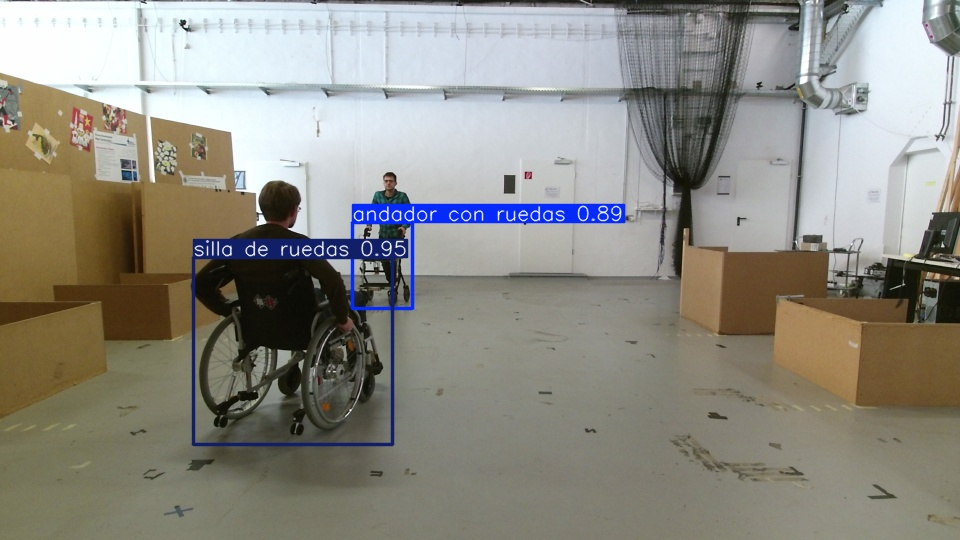

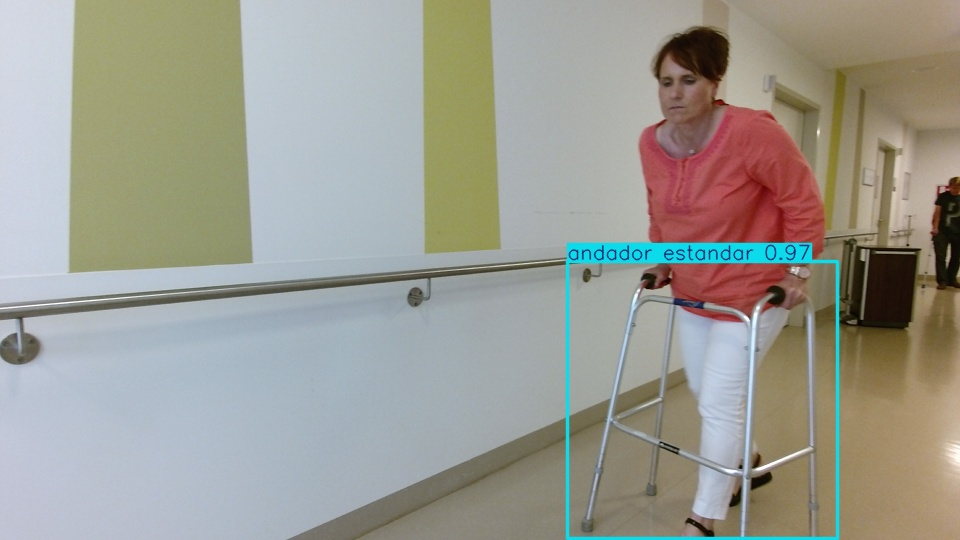

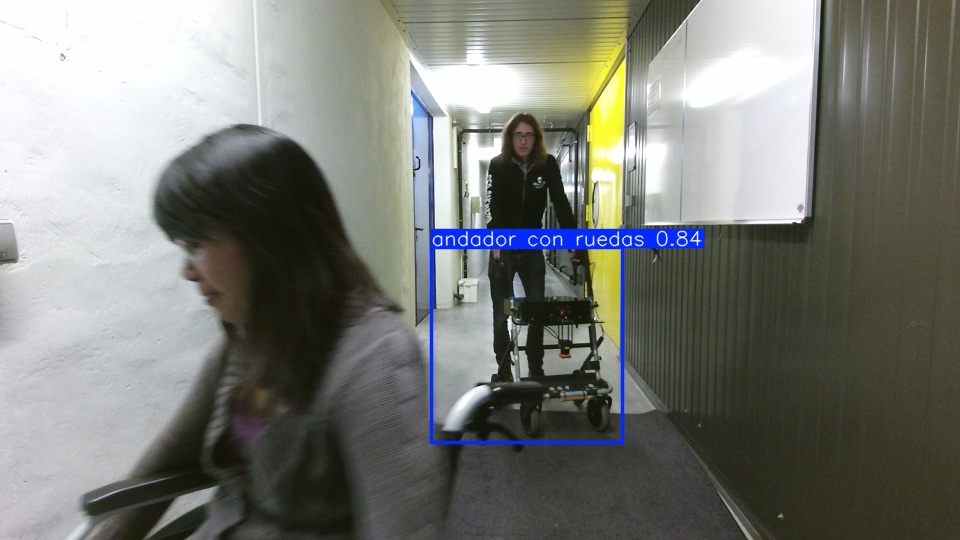

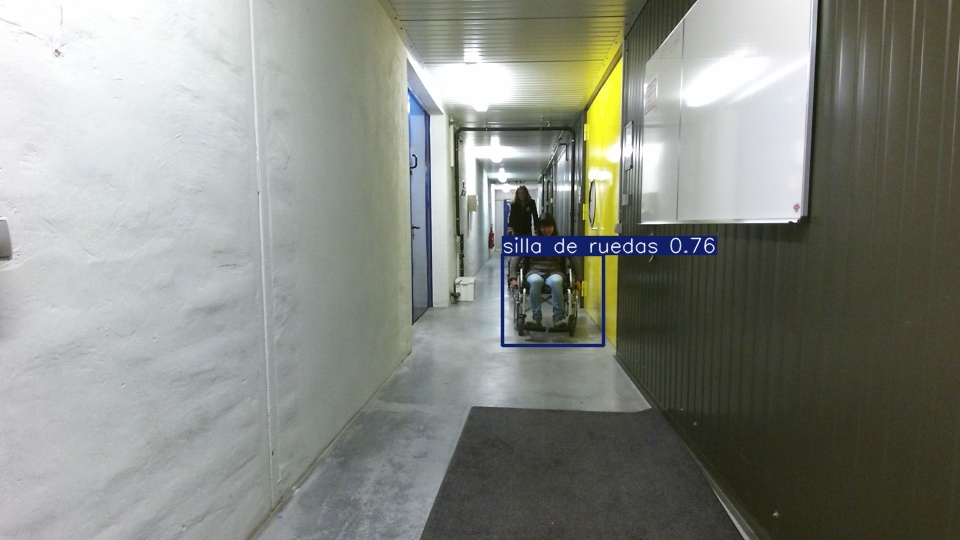

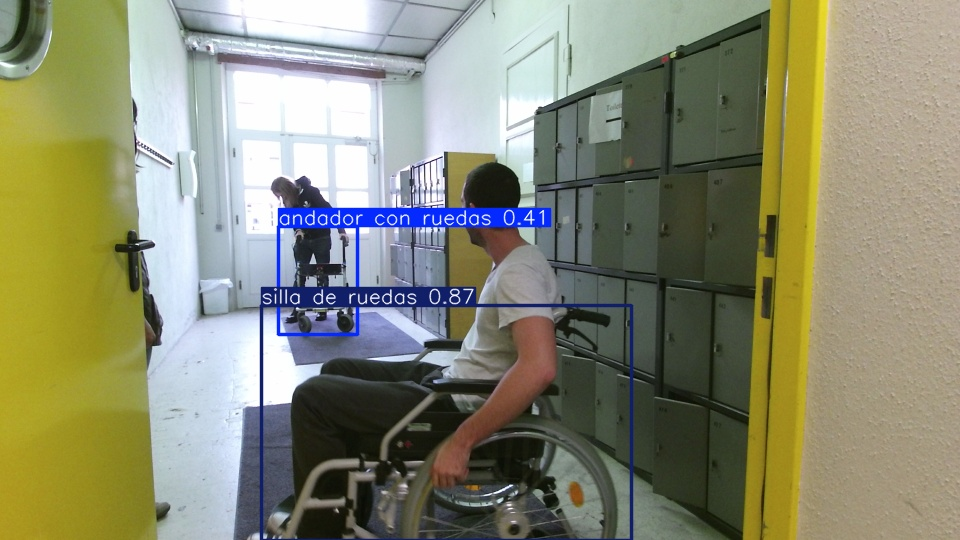

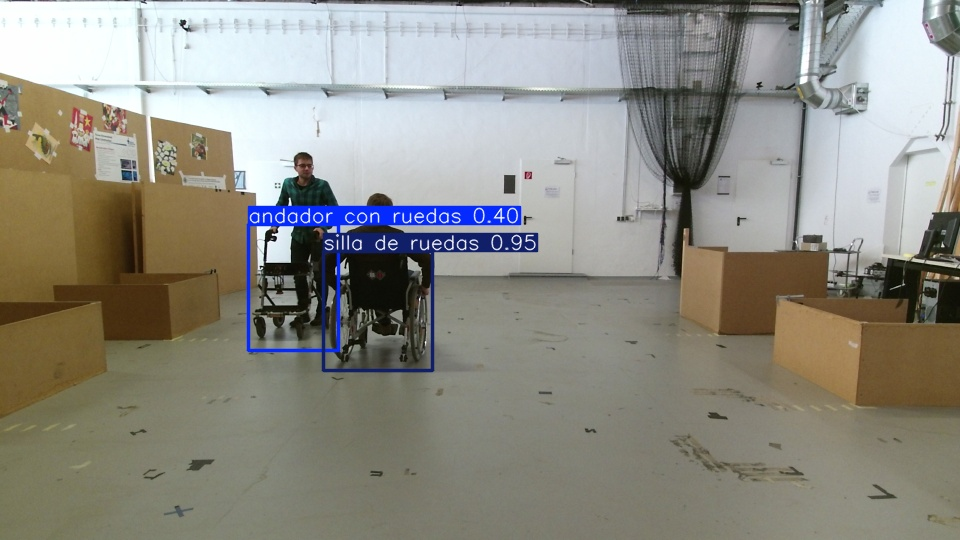

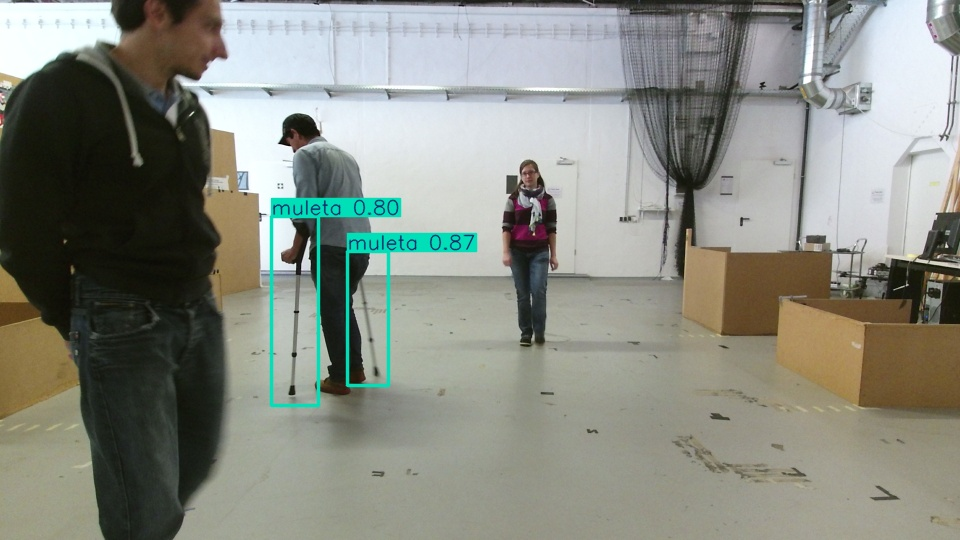

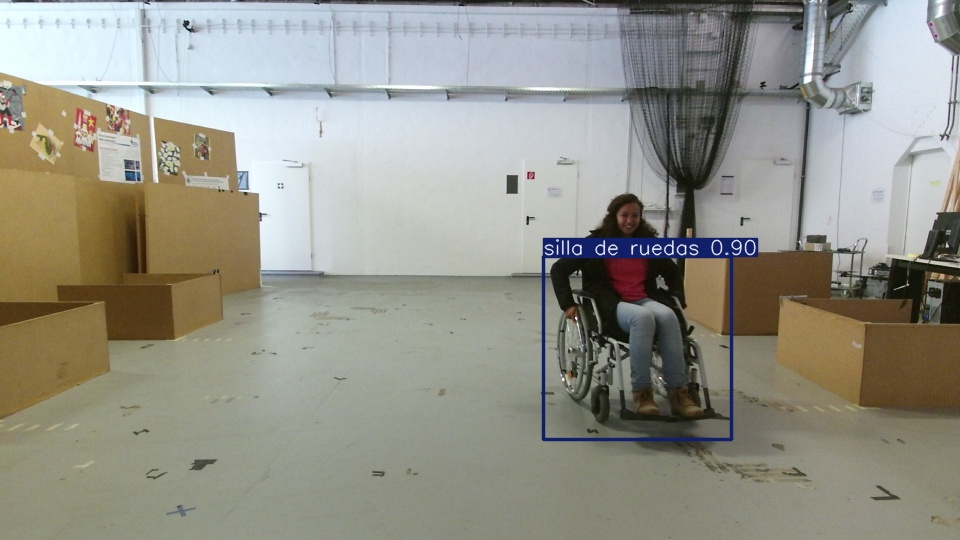

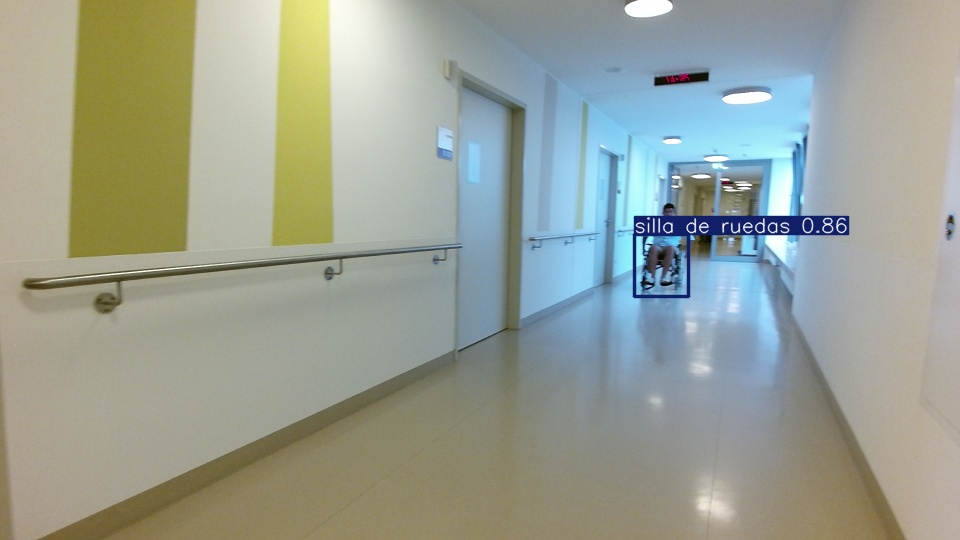

In [14]:
import glob
from IPython.display import Image, display
for image_path in glob.glob(f'/content/runs/detect/predict/*.jpg')[:10]:
  display(Image(filename=image_path, height=400))
  print('\n')


Si no detecta objetos correctamente, deberíamos ajustar de la siguiente forma:

1. Revisar el conjunto de datos para asegurarnos de que no haya errores de etiquetado ni ejemplos contradictorios.

2. Aumentar el número de epochs utilizadas para el entrenamiento.

3. Usar un tamaño de modelo mayor (p. ej., `yolov8l.pt`).

4. Agrega más imágenes al conjunto de datos de entrenamiento para mejorar la precisión del modelo.
* Edje dispone de un video de consulta para estos casos de conjuntos de datos (https://www.youtube.com/watch?v=v0ssiOY6cfg)


También puedes ejecutar el modelo en archivos de vídeo u otras imágenes subiéndolos a este notebook y usando el comando `!yolo detect predict` mencionado anteriormente, donde `source` apunta a la ubicación del archivo de vídeo, la imagen o la carpeta de imágenes.

Los resultados se guardarán en `runs/detect/predict`.




---



Dibujar cuadros en imágenes es genial, pero no es muy útil por sí solo.

Tampoco resulta muy útil ejecutar estos modelos en un notebook de Colab: es más fácil si podemos ejecutarlo en un ordenador local.

## Deploy de modelo

Ahora que el modelo personalizado está entrenado, podemos descargarlo e implementarlo en una aplicación Los modelos YOLO pueden ejecutarse en una amplia variedad de hardware, incluyendo PC, sistemas integrados y teléfonos.

Ultralytics facilita la conversión de los modelos YOLO a varios formatos (`tflite`, `onnx`, etc.) y su implementación en diversos entornos.

Esta sección muestra cómo descargar el modelo y proporciona enlaces a instrucciones para implementarlo en tu PC y dispositivos periféricos como Raspberry Pi.

### Descarga de modelo

### Deploy local

## Conclusiones